In [1]:
# from datagenerator import jet_data_generator 
from datagenerator_realistic import jet_data_generator as realistic_generator

from plotutils import plot_event 
import matplotlib.pyplot as plt
import time
import torch
import pandas as pd
import os
import numpy as np

In [2]:
def delta_hyp(dismat):
    p = 0
    row = dismat[p, :][None, :]
    col = dismat[:, p][:, None]
    XY_p = 0.5 * (row + col - dismat)
    maxmin = torch.minimum(XY_p[:, :, None], XY_p[None, :, :]).max(1).values
    return (maxmin - XY_p).max()

In [3]:
dataset = torch.load('Toy_datasets/dataset_nprong2_nparts32_0.pt')

In [57]:
import numpy as np
import torch

def resample_particles(dataset, percents, method='perturbation'):
    """
    Resample the dataset at the per-particle level, preserving original ordering.

    Parameters
    ----------
    dataset : list
        A data structure holding your events and particles. We use dataset[3][i]
        to access the i-th event.
    percents : list of float
        Percentages of particles to resample (0.1, 0.2, etc.).
    method : str
        Either 'perturbation' or 'replacement'.

    Returns
    -------
    resampled_dict : dict
        Dictionary: {percent -> [Tensor of shape (n_particles, 3) per event]}, 
        containing the final resampled four-vectors for each event, in original order.
    resampled_prong_labels_dict : dict
        Dictionary: {percent -> [list of prong labels per event]},
        in the same order as the four-vectors for that event.
    four_vectors_mean : Tensor
        Per-event mean of the original four vectors, shape (n_events, 3).
    four_vectors_std : Tensor
        Per-event std of the original four vectors, shape (n_events, 3).
    """
    data_samples = len(dataset[3])  # number of events in dataset[3]

    # For storing the original data means & stds
    four_vectors = []
    four_vectors_mean = []
    four_vectors_std = []

    # For storing resampled data (and prong labels) for each percentage
    resampled_dict = {p: [] for p in percents}
    resampled_prong_labels_dict = {p: [] for p in percents}

    # Loop over each event
    for i in range(data_samples):
        # Grab all particles in the i-th event
        all_particles = dataset[3][i]

        # Get prong labels as a NumPy array for easy indexing
        prong_labels = np.array([part.prong_label for part in all_particles])
        all_prong_labels = np.unique(prong_labels)

        # Build array of [E, eta, phi]
        e_eta_phi = []
        for part in all_particles:
            mom = part.mom
            e_eta_phi.append([mom.e, mom.eta.item(), mom.phi.item()])
        e_eta_phi = np.array(e_eta_phi, dtype=np.float32)
        
        # Convert to a torch.Tensor
        four_momentum_tensor = torch.from_numpy(e_eta_phi)  # shape (N, 3)

        # Compute means and stds for each prong label
        prong_stats = {}
        for prong in all_prong_labels:
            # Indices for this prong
            prong_indices = np.where(prong_labels == prong)[0]
            prong_tensor = four_momentum_tensor[prong_indices]
            prong_mean = prong_tensor.mean(dim=0)  # (mean_e, mean_eta, mean_phi)
            prong_std = prong_tensor.std(dim=0)    # (std_e,  std_eta,  std_phi)
            prong_stats[prong] = (prong_mean, prong_std)

        # Save original data stats for this event
        four_vectors.append(four_momentum_tensor)
        four_vectors_mean.append(four_momentum_tensor.mean(dim=0))
        four_vectors_std.append(four_momentum_tensor.std(dim=0))

        # Make an array of all particle indices for this event
        indices = np.arange(len(all_particles))

        # For each percent, generate a resampled version of the event
        for percent in percents:
            num_resample = int(len(all_particles) * percent)

            # Randomly pick which particles to resample
            resample_indices = np.random.choice(indices, num_resample, replace=False)

            # Create a copy of the original four vectors to modify in-place
            # So the final output remains in the original order
            resampled_view = four_momentum_tensor.clone()

            # We don't need to change prong labels if we keep the same prong.
            # We'll just keep them as is, in the same original order:
            final_prong_labels = prong_labels.copy()

            # For each prong, identify which indices in 'resample_indices' are that prong
            for prong in all_prong_labels:
                mean_vec, std_vec = prong_stats[prong]

                # Indices in the original event that belong to 'prong'
                prong_mask_in_all = (prong_labels == prong)

                # Indices of the chosen resamples that belong to this prong
                # (i.e. intersection of prong_mask_in_all and resample_indices)
                prong_resample_mask = np.isin(resample_indices, np.where(prong_mask_in_all)[0])
                # E.g. [True, False, True, ...] among the resample_indices array

                # Find the actual positions in 'resample_indices' that are True
                prong_resample_positions = np.where(prong_resample_mask)[0]
                n_resamples = len(prong_resample_positions)
                if n_resamples == 0:
                    continue  # No resampling for this prong

                # The original event indices where we must generate new data:
                # e.g. if resample_indices = [2,5,7], prong_resample_positions might be [0,2],
                # meaning resample_indices[0] = 2, resample_indices[2] = 7 -> those are the real indices
                target_indices = resample_indices[prong_resample_positions]

                # Now generate new data for those indices
                if method == 'perturbation':
                    # Zero-mean normal with prong std
                    dE = torch.normal(mean=0.0, std=std_vec[0], size=(n_resamples,))
                    dEta = torch.normal(mean=0.0, std=std_vec[1], size=(n_resamples,))
                    dPhi = torch.normal(mean=0.0, std=std_vec[2], size=(n_resamples,))
                    # If you're debugging label issues, you can temporarily zero these out:
                    # dE   = 0*dE
                    # dEta = 0*dEta
                    # dPhi = 0*dPhi

                    perturbation = torch.stack([dE.abs(), dEta, dPhi], dim=1)
                    # Add the perturbation to the original
                    original_vals = resampled_view[target_indices]  # shape (n_resamples, 3)
                    new_vals = original_vals + perturbation
                    resampled_view[target_indices] = new_vals

                elif method == 'replacement':
                    # Full sampling from the prong distribution
                    E_new = torch.normal(mean=mean_vec[0], std=std_vec[0], size=(n_resamples,)).abs()
                    eta_new = torch.normal(mean=mean_vec[1], std=std_vec[1], size=(n_resamples,))
                    phi_new = torch.normal(mean=mean_vec[2], std=std_vec[2], size=(n_resamples,))
                    new_vals = torch.stack([E_new, eta_new, phi_new], dim=1)
                    resampled_view[target_indices] = new_vals

                else:
                    raise ValueError("Method must be either 'perturbation' or 'replacement'")

            # Done with all prongs; now we have a fully resampled event in original index order
            # Save it in our dict
            resampled_dict[percent].append(resampled_view)
            # Save the final labels in the same order
            resampled_prong_labels_dict[percent].append(final_prong_labels.tolist())

    # Convert per-event means and stds into Tensors
    four_vectors_mean = torch.stack(four_vectors_mean, dim=0)
    four_vectors_std  = torch.stack(four_vectors_std,  dim=0)

    return resampled_dict, resampled_prong_labels_dict, four_vectors_mean, four_vectors_std


In [5]:
def calculate_gromov_delta(resampled_dict):
    gromov_outputs = []

    for percent, resampled_jets in resampled_dict.items():
        for four_momentum_tensor in resampled_jets:
            # Extract energy, eta, phi
            energies = four_momentum_tensor[:, 0]
            normalized_energies = energies / energies.sum()
            energies = normalized_energies
            etas = four_momentum_tensor[:, 1]
            phis = four_momentum_tensor[:, 2]

            # Compute pairwise energy differences
            energy_diffs = torch.abs(energies[:, None] - energies[None, :])
            delta_eta = etas[:, None] - etas[None, :]
            delta_phi = phis[:, None] - phis[None, :]
            delta_phi = torch.remainder(delta_phi + np.pi, 2 * np.pi) - np.pi
            delta_R = torch.sqrt(delta_eta ** 2 + delta_phi ** 2)

            R = 1
            dists = (energy_diffs * delta_R) / R
            delta = delta_hyp(dists)
            diam = dists.max()
            rel_delta = (2 * delta) / diam

            gromov_outputs.append({
                'delta': delta.item(),
                'rel_delta': rel_delta.item(),
                'percent': percent
            })

    df = pd.DataFrame(gromov_outputs)
    return df




In [6]:
gromov_outputs = []
data_samples = len(dataset[3])

for i in range(data_samples):
    all_particles = dataset[3][i]
    e_eta_phi = []

    for part in all_particles:
        mom = part.mom
        e_eta_phi.append([mom.e, mom.eta.item(), mom.phi.item()])

    e_eta_phi = np.array(e_eta_phi)
    four_momentum_tensor = torch.tensor(e_eta_phi)

    # Extract energy, eta, phi
    energies = four_momentum_tensor[:, 0]
    normalized_energies = energies / energies.sum()
    energies = normalized_energies
    etas = four_momentum_tensor[:, 1]
    phis = four_momentum_tensor[:, 2]

    # Compute pairwise energy differences
    energy_diffs = torch.abs(energies[:, None] - energies[None, :])
    delta_eta = etas[:, None] - etas[None, :]
    delta_phi = phis[:, None] - phis[None, :]
    delta_phi = torch.remainder(delta_phi + np.pi, 2 * np.pi) - np.pi
    delta_R = torch.sqrt(delta_eta ** 2 + delta_phi ** 2)

    R = 1
    dists = (energy_diffs * delta_R) / R
    delta = delta_hyp(dists)
    diam = dists.max()
    rel_delta = (2 * delta) / diam

    gromov_outputs.append({
        'delta': delta.item(),
        'rel_delta': rel_delta.item(),
        'n_parts': 32,
        'quark_mass': 1
    })
df = pd.DataFrame(gromov_outputs)

In [58]:
percents = [0.25, 0.5, 1]

perturb_resampled_dict,perturb_resampled_prong_labels, four_vectors_mean, four_vectors_std = resample_particles(dataset, percents=percents, method='perturbation')
replace_resampled_dict,replace_resampled_prong_labels, four_vectors_mean, four_vectors_std = resample_particles(dataset, percents=percents, method='replacement')
gromov_df_resample = calculate_gromov_delta(replace_resampled_dict)
gromov_df_replacement = calculate_gromov_delta(perturb_resampled_dict)

In [ ]:
import matplotlib.pyplot as plt

def plot_resampled_data(dataset, perturb_resampled_dict,perturb_resampled_prong_labels, replace_resampled_dict, replace_resampled_prong_labels, percents):
    # Randomly select an index
    random_index = np.random.randint(0, len(dataset[3]))

    # Get the four vectors and prong labels for the selected index
    all_particles = dataset[3][random_index]
    e_eta_phi = []
    prong_labels = [part.prong_label for part in all_particles]

    for part in all_particles:
        mom = part.mom
        e_eta_phi.append([mom.e, mom.eta.item(), mom.phi.item()])

    e_eta_phi = np.array(e_eta_phi)
    four_momentum_tensor = torch.tensor(e_eta_phi)

    # Extract energy, eta, phi
    energies = four_momentum_tensor[:, 0]
    etas = four_momentum_tensor[:, 1]
    phis = four_momentum_tensor[:, 2]

    # Plot the original four vectors in eta-phi space
    fig, axs = plt.subplots(len(percents), 3, figsize=(18, 6 * len(percents)))

    for i, percent in enumerate(percents):
        scatter = axs[i, 0].scatter(etas, phis, s=energies * 10, c=prong_labels, cmap='viridis', alpha=0.6)
        axs[i, 0].set_xlabel('Eta')
        axs[i, 0].set_ylabel('Phi')
        axs[i, 0].set_title(f'Original Four Vectors\nin Eta-Phi Space (Percent: {percent})')
        axs[i, 0].set_xlim([-1, 1])
        axs[i, 0].set_ylim([-1, 1])
        legend1 = axs[i, 0].legend(*scatter.legend_elements(), title="Prong")
        axs[i, 0].add_artist(legend1)

        # Plot the resampled four vectors (perturbation) in eta-phi space
        resampled_four_vecs_perturb = perturb_resampled_dict[percent][random_index]
        energies_resampled_perturb = resampled_four_vecs_perturb[:, 0]
        etas_resampled_perturb = resampled_four_vecs_perturb[:, 1]
        phis_resampled_perturb = resampled_four_vecs_perturb[:, 2]
        cur_prong_label = perturb_resampled_prong_labels[percent][random_index]

        
        scatter = axs[i, 1].scatter(etas_resampled_perturb, phis_resampled_perturb, s=energies_resampled_perturb * 10, c=prong_labels, cmap='viridis', alpha=0.6)
        axs[i, 1].set_xlabel('Eta')
        axs[i, 1].set_ylabel('Phi')
        axs[i, 1].set_title(f'Resampled (Perturbation)\nFour Vectors in Eta-Phi Space (Percent: {percent})')
        axs[i, 1].set_xlim([-1, 1])
        axs[i, 1].set_ylim([-1, 1])
        legend2 = axs[i, 1].legend(*scatter.legend_elements(), title="Prong")
        axs[i, 1].add_artist(legend2)

        # Plot the resampled four vectors (replacement) in eta-phi space
        resampled_four_vecs_replace = replace_resampled_dict[percent][random_index]
        energies_resampled_replace = resampled_four_vecs_replace[:, 0]
        etas_resampled_replace = resampled_four_vecs_replace[:, 1]
        phis_resampled_replace = resampled_four_vecs_replace[:, 2]
        cur_prong_label = replace_resampled_prong_labels[percent][random_index]


        scatter = axs[i, 2].scatter(etas_resampled_replace, phis_resampled_replace, s=energies_resampled_replace * 10, c=prong_labels, cmap='viridis', alpha=0.6)
        axs[i, 2].set_xlabel('Eta')
        axs[i, 2].set_ylabel('Phi')
        axs[i, 2].set_title(f'Resampled (Replacement)\nFour Vectors in Eta-Phi Space (Percent: {percent})')
        axs[i, 2].set_xlim([-1, 1])
        axs[i, 2].set_ylim([-1, 1])
        legend3 = axs[i, 2].legend(*scatter.legend_elements(), title="Prong")
        axs[i, 2].add_artist(legend3)

    plt.tight_layout()
    plt.show()

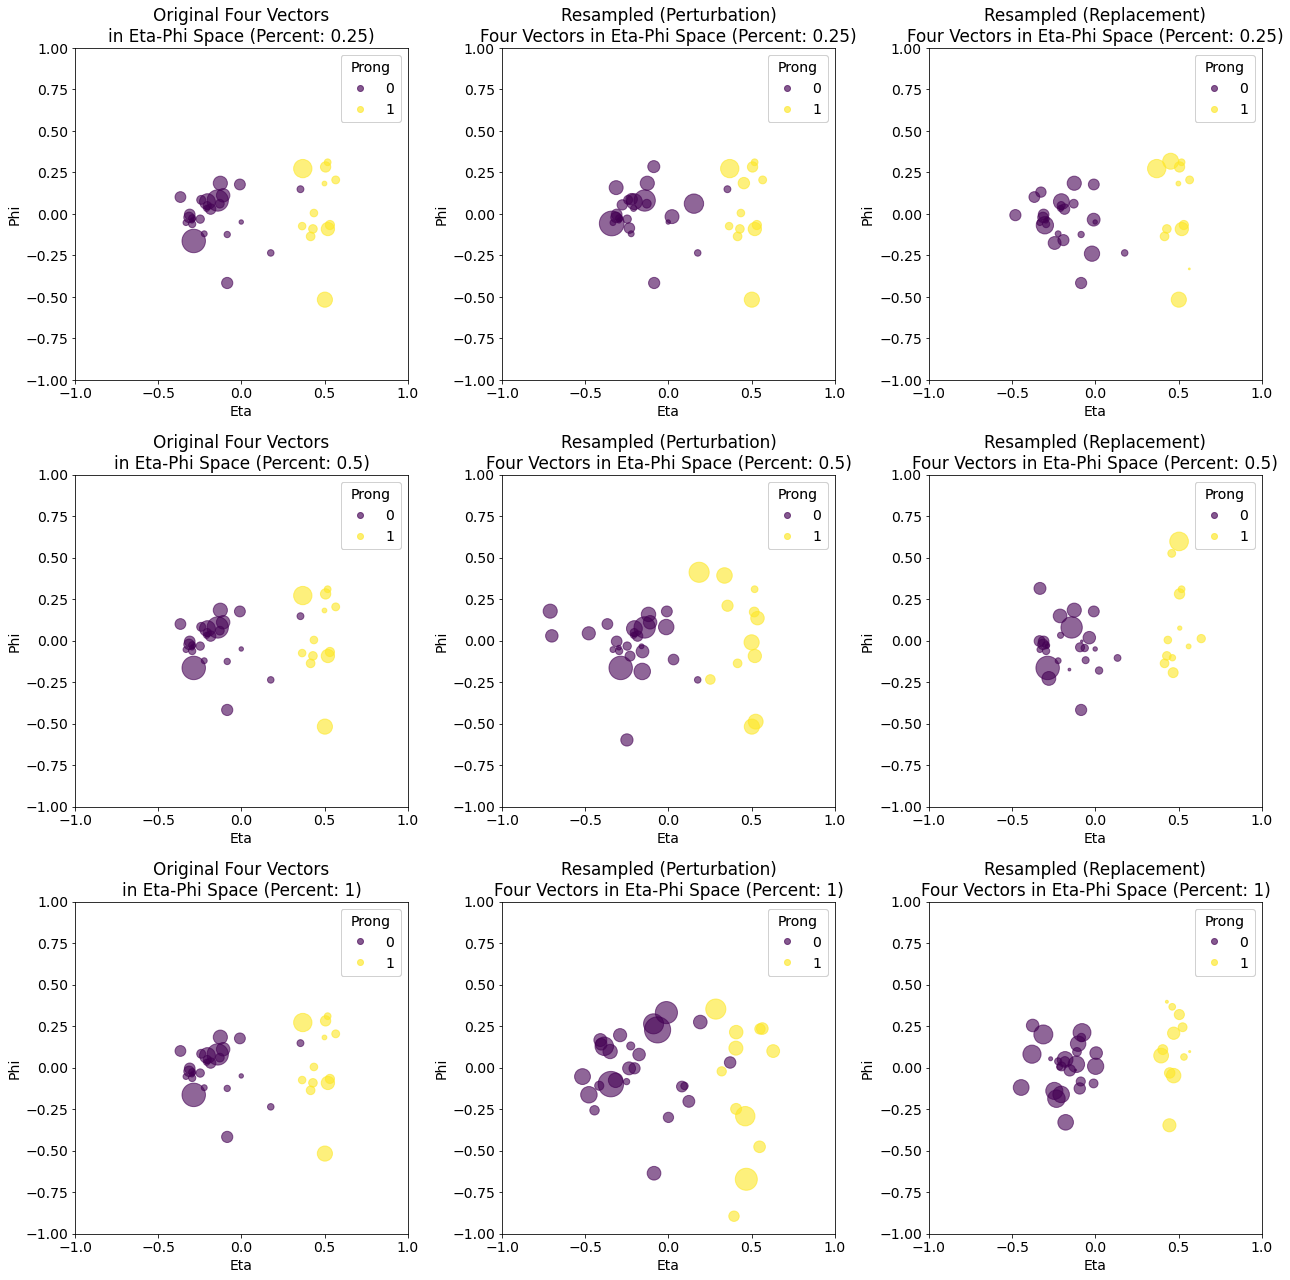

In [59]:
# Example usage:
plot_resampled_data(dataset, perturb_resampled_dict,perturb_resampled_prong_labels, replace_resampled_dict,replace_resampled_prong_labels, percents)

In [51]:
all_particles = dataset[3][0]
prong_labels = [part.prong_label for part in all_particles]

False

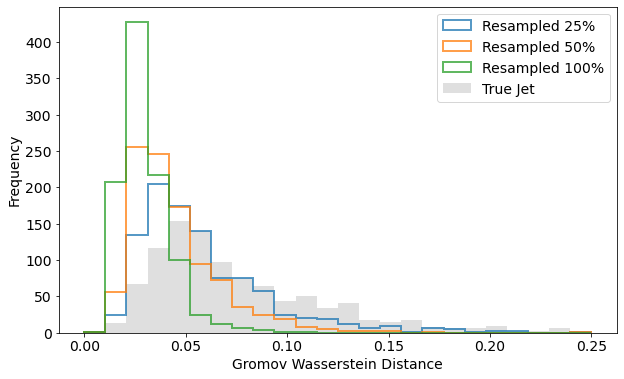

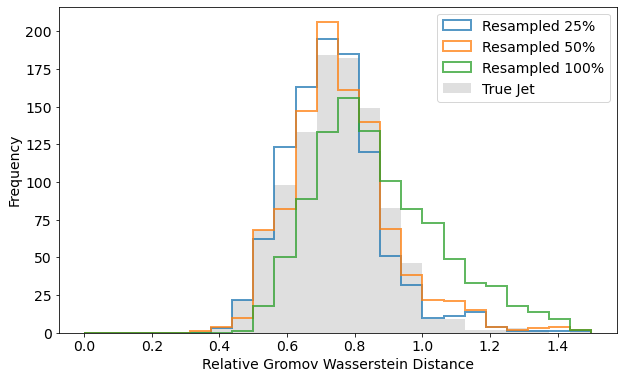

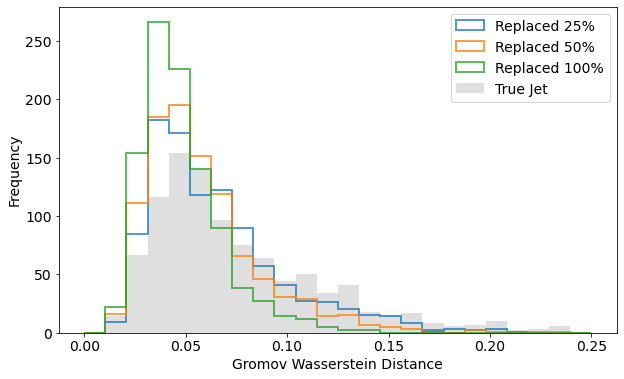

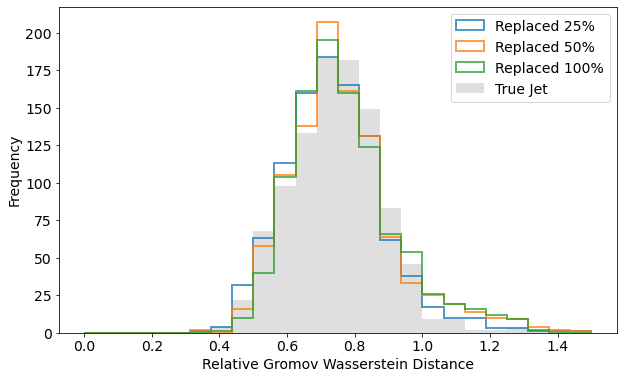

In [ ]:
resampled = gromov_df_resample.groupby('percent')
replacement = gromov_df_replacement.groupby('percent')

bins = np.linspace(0, 0.25, 25)
plt.figure(figsize=(10, 6))
for percent in percents:
    plt.hist(resampled.get_group(percent)['delta'], 
             bins=bins, alpha=0.75, 
             label=f'Resampled {int(100*percent)}%',histtype='step',
             linewidth=2)
plt.hist(df['delta'], bins=bins, alpha=0.25, label='True Jet', color='grey')
plt.legend()
plt.xlabel('Gromov Wasserstein Distance')   
plt.ylabel('Frequency')
plt.show()

bins = np.linspace(0, 1.5, 25)

plt.figure(figsize=(10, 6))
for percent in percents:
    plt.hist(resampled.get_group(percent)['rel_delta'], 
                bins=bins, alpha=0.75, 
                label=f'Resampled {int(100*percent)}%',histtype='step',
                linewidth=2)
plt.hist(df['rel_delta'], bins=bins, alpha=0.25, label='True Jet', color='grey')
plt.legend()
plt.xlabel('Relative Gromov Wasserstein Distance')   
plt.ylabel('Frequency')
plt.show()



bins = np.linspace(0, 0.25, 25)
plt.figure(figsize=(10, 6))
for percent in percents:
    plt.hist(replacement.get_group(percent)['delta'], 
             bins=bins, alpha=0.75, 
             label=f'Replaced {int(100*percent)}%',histtype='step',
             linewidth=2)
plt.hist(df['delta'], bins=bins, alpha=0.25, label='True Jet', color='grey')
plt.legend()
plt.xlabel('Gromov Wasserstein Distance')   
plt.ylabel('Frequency')
plt.show()

bins = np.linspace(0, 1.5, 25)

plt.figure(figsize=(10, 6))
for percent in percents:
    plt.hist(replacement.get_group(percent)['rel_delta'], 
                bins=bins, alpha=0.75, 
                label=f'Replaced {int(100*percent)}%',histtype='step',
                linewidth=2)
plt.hist(df['rel_delta'], bins=bins, alpha=0.25, label='True Jet', color='grey')
plt.legend()
plt.xlabel('Relative Gromov Wasserstein Distance')   
plt.ylabel('Frequency')
plt.show()

In [17]:
gromov_outputs = []
data_samples = len(dataset[3])
four_vectors = []
for i in range(data_samples):
    all_particles = dataset[3][i]
    e_eta_phi = []

    for part in all_particles:
        mom = part.mom
        e_eta_phi.append([mom.e, mom.eta.item(), mom.phi.item()])

    e_eta_phi = np.array(e_eta_phi)
    four_momentum_tensor = torch.tensor(e_eta_phi)

    # Extract energy, eta, phi
    energies = four_momentum_tensor[:, 0]
    normalized_energies = energies / energies.sum()
    energies = normalized_energies
    etas = four_momentum_tensor[:, 1]
    phis = four_momentum_tensor[:, 2]

    # Compute pairwise energy differences
    energy_diffs = torch.abs(energies[:, None] - energies[None, :])
    delta_eta = etas[:, None] - etas[None, :]
    delta_phi = phis[:, None] - phis[None, :]
    delta_phi = torch.remainder(delta_phi + np.pi, 2 * np.pi) - np.pi
    delta_R = torch.sqrt(delta_eta ** 2 + delta_phi ** 2)

    R = 1
    dists = (energy_diffs * delta_R) / R
    delta = delta_hyp(dists)

    gromov_outputs.append({
        'delta': delta.item(),
        'n_parts': 32,
        'quark_mass': 1
    })
df = pd.DataFrame(gromov_outputs)
grouped = df.groupby(['n_parts', 'quark_mass'])
grouped.mean()

,,delta
n_parts,quark_mass,
32,1,0.072965


In [32]:

def generate_and_save_datasets():
    for qmass in quark_mass:
        for npts in n_parts:
            realistic_sig_2p_16part = realistic_generator("signal", qmass, npts, True)
            start = time.time()
            dataset = realistic_sig_2p_16part.generate_dataset(num_samples)
            end = time.time()

            print(f"Generated dataset for quark mass {qmass}, n_parts {npts} in {end - start:.2f}s")

            # Save dataset to a folder with naming convention
            filename = f"{output_folder}/dataset_qmass{qmass}_nparts{npts}.pt"
            torch.save(dataset, filename)
            print(f"Saved to {filename}")

In [19]:
def process_datasets():
    gromov_outputs = []

    for qmass in quark_mass:
        for npts in n_parts:
            filename = f"{output_folder}/dataset_qmass{qmass}_nparts{npts}.pt"

            if os.path.exists(filename):
                dataset = torch.load(filename)
                data_samples = len(dataset[3])

                for i in range(data_samples):
                    all_particles = dataset[3][i]
                    e_eta_phi = []

                    for part in all_particles:
                        mom = part.mom
                        e_eta_phi.append([mom.e, mom.eta.item(), mom.phi.item()])

                    e_eta_phi = np.array(e_eta_phi)
                    four_momentum_tensor = torch.tensor(e_eta_phi)

                    # Extract energy, eta, phi
                    energies = four_momentum_tensor[:, 0]
                    normalized_energies = energies / energies.sum()
                    energies = normalized_energies
                    etas = four_momentum_tensor[:, 1]
                    phis = four_momentum_tensor[:, 2]

                    # Compute pairwise energy differences
                    energy_diffs = torch.abs(energies[:, None] - energies[None, :])
                    delta_eta = etas[:, None] - etas[None, :]
                    delta_phi = phis[:, None] - phis[None, :]
                    delta_phi = torch.remainder(delta_phi + np.pi, 2 * np.pi) - np.pi
                    delta_R = torch.sqrt(delta_eta ** 2 + delta_phi ** 2)

                    R = 1
                    dists = (energy_diffs * delta_R) / R
                    delta = delta_hyp(dists)

                    gromov_outputs.append({
                        'delta': delta.item(),
                        'n_parts': npts,
                        'quark_mass': qmass
                    })

            else:
                print(f"Dataset not found: {filename}")

    return gromov_outputs

In [ ]:
generate_and_save_datasets()

In [20]:
output = process_datasets()

Dataset not found: gromov_testing_datasets/dataset_qmass10_nparts64.pt


In [21]:
df = pd.DataFrame(output)
grouped = df.groupby(['n_parts', 'quark_mass'])
grouped.mean()

In [23]:
grouped = df.groupby(['n_parts', 'quark_mass'])


delta
n_parts quark_mass          
16      2           0.090119
        5           0.109431
        10          0.129188
32      2           0.076833
        5           0.093088
        10          0.111844
64      2           0.068073
        5           0.077296

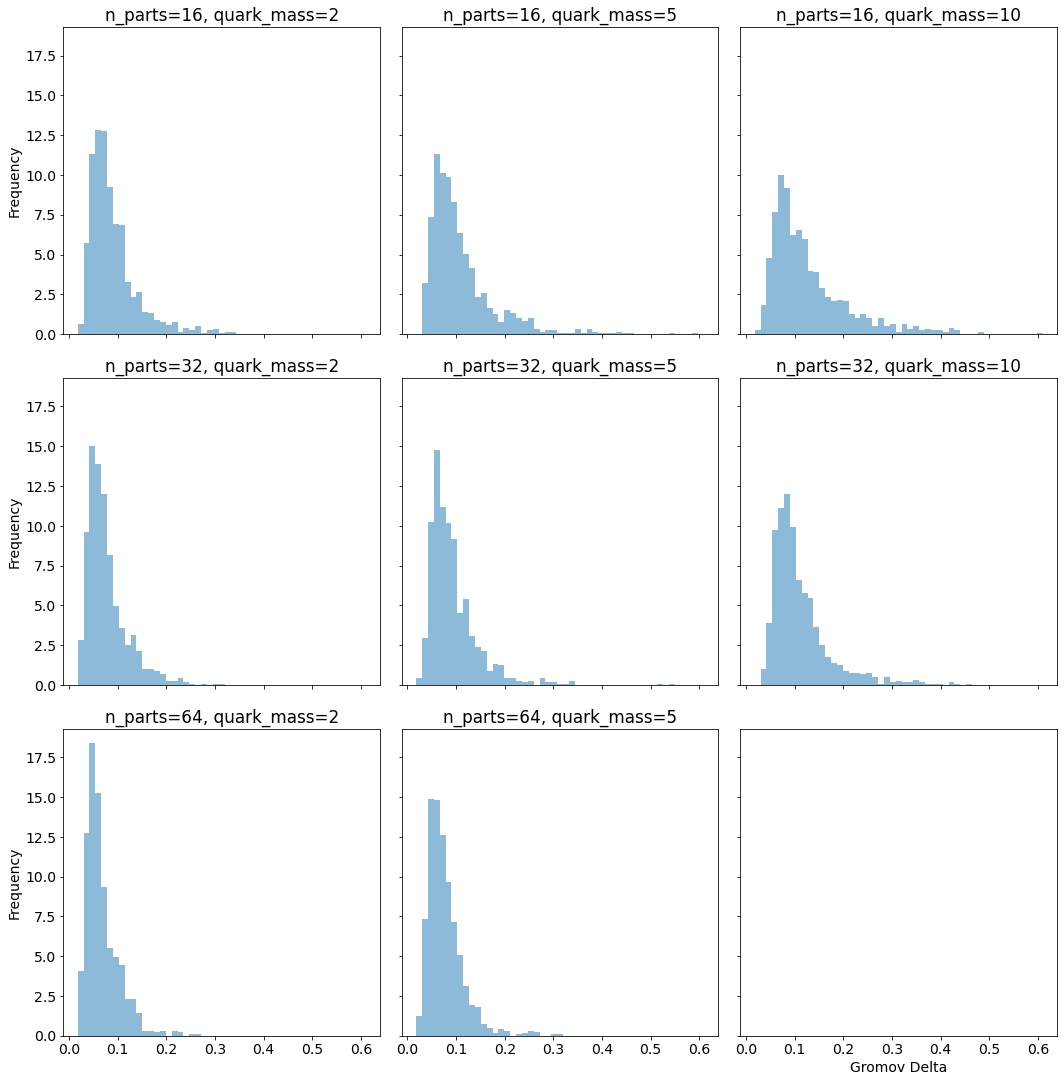

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
axes = axes.flatten()

bins = np.linspace(df['delta'].min(), df['delta'].max(), 50)

for ax, ((n_parts, quark_mass), group) in zip(axes, grouped):
    group['delta'].plot.hist(ax=ax, bins=bins, density=True, alpha=0.5)
    ax.set_title(f'n_parts={n_parts}, quark_mass={quark_mass}')
    
plt.tight_layout()
plt.xlabel('Gromov Delta')
plt.ylabel('Density')
plt.show()

,,delta
n_parts,quark_mass,
16,2,0.096976
32,2,0.057278
64,2,0.050756


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

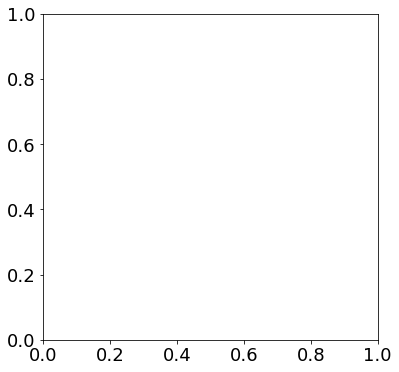

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(realisticdata_sig_2p_16part[1][:,0],alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(realisticdata_sig_2p_16part[1][:,1],alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
ax.set_yscale('log')
#fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.png')
#fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.pdf')

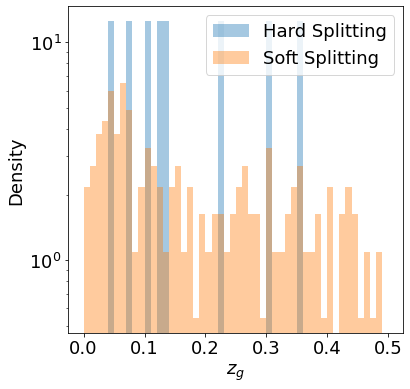

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(realistic_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(realistic_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
ax.set_yscale('log')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.png')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.pdf')

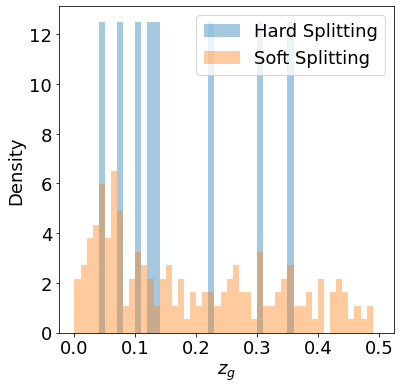

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(realistic_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(realistic_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing.png')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing.pdf')

In [22]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt

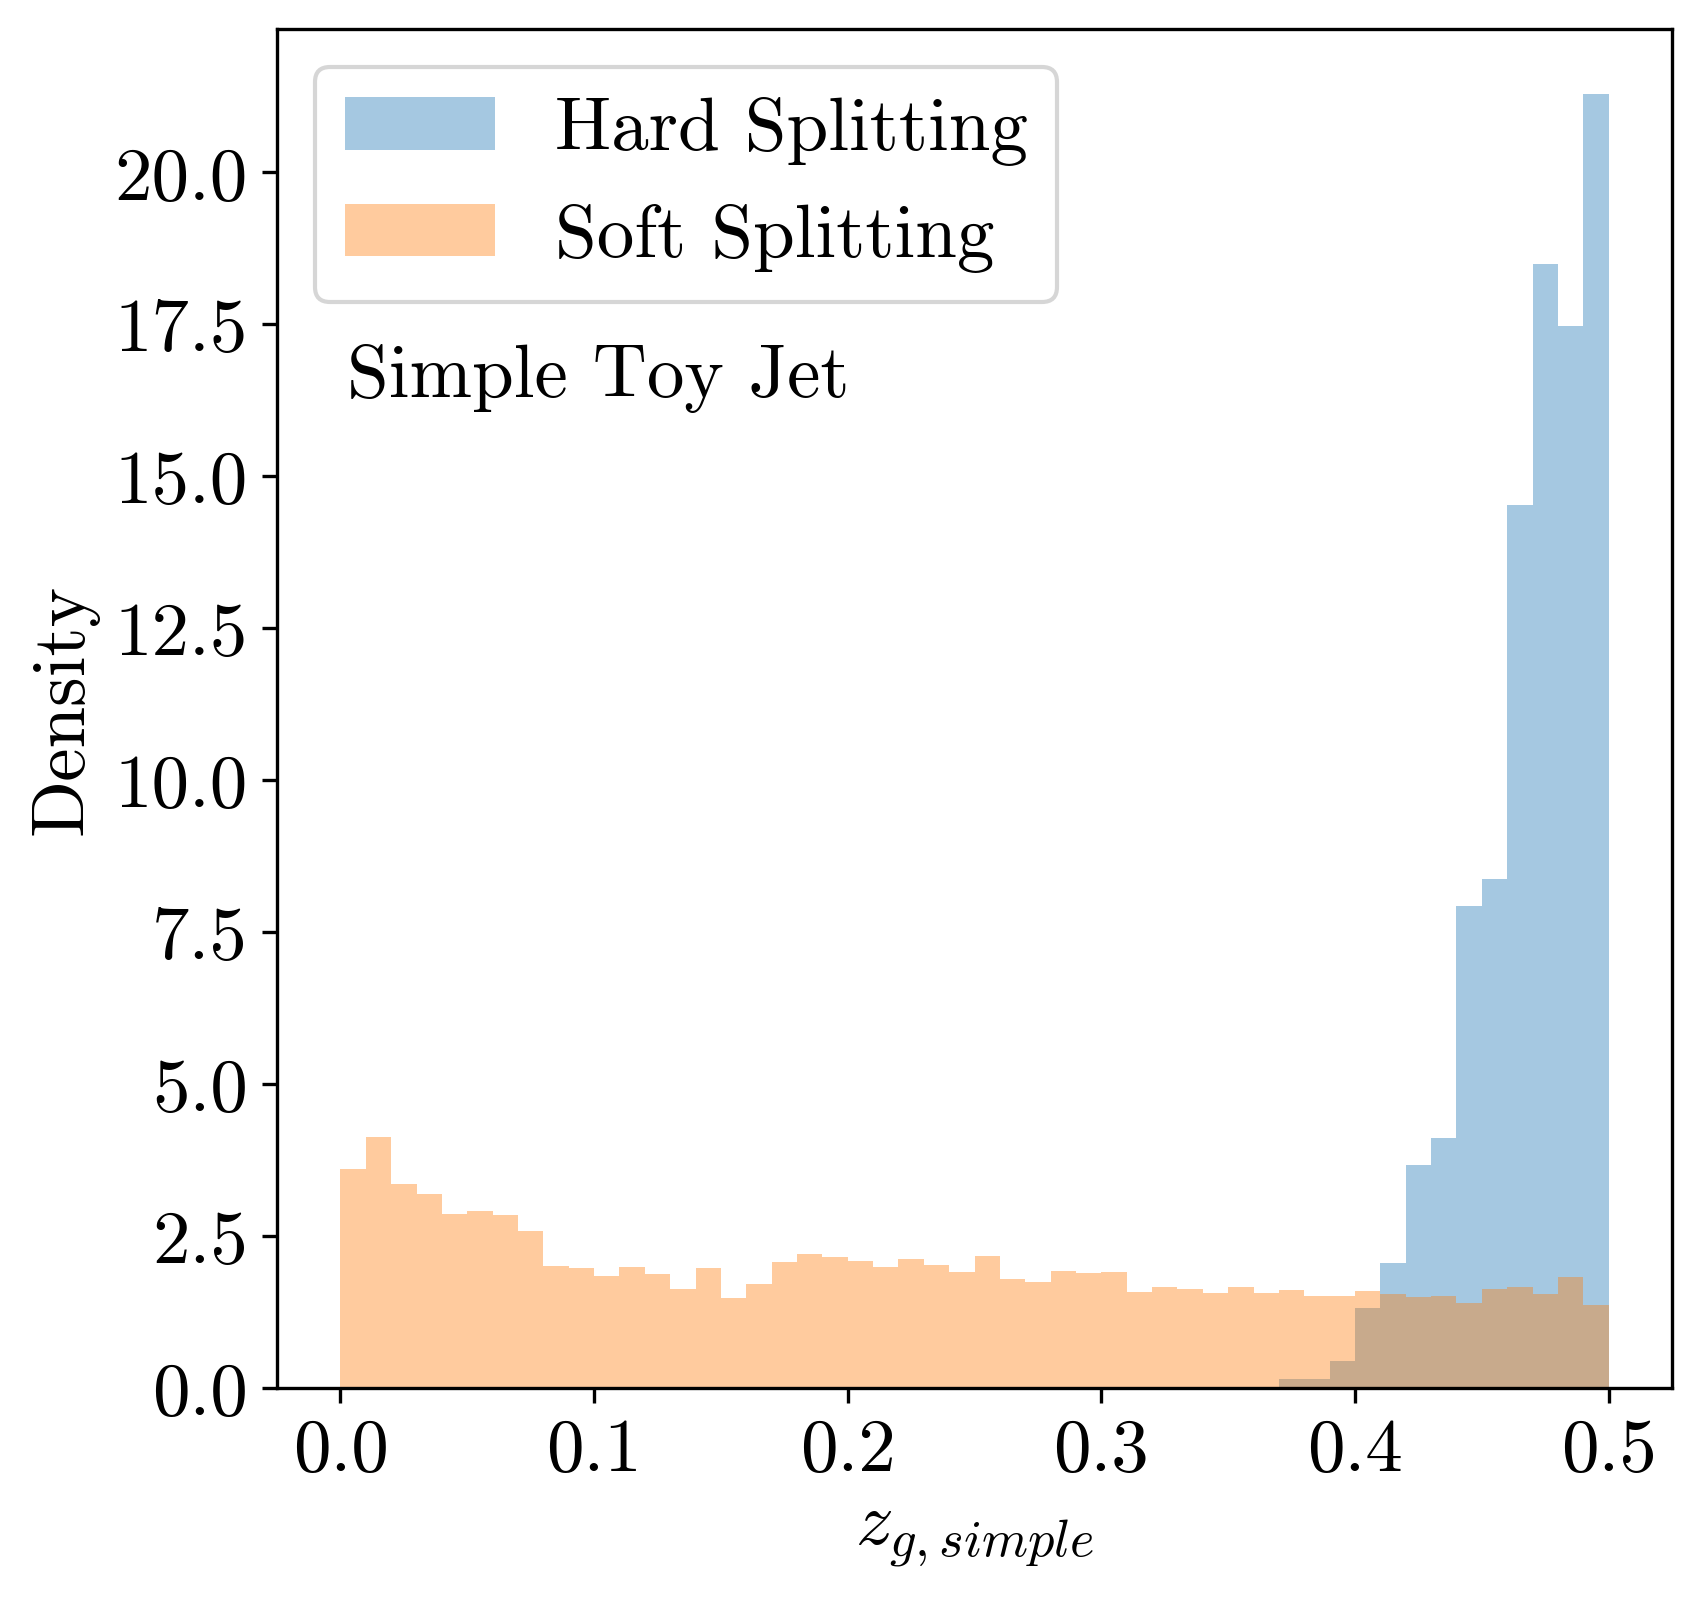

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g, simple}$')
ax.set_ylabel('Density')
ax.text(0.05, 0.73, 'Simple Toy Jet', transform=ax.transAxes)

fig.savefig('./figures/paper_JHEP/SimpleToyJet_Zg.png')
fig.savefig('./figures/paper_JHEP/SimpleToyJet_Zg.pdf')

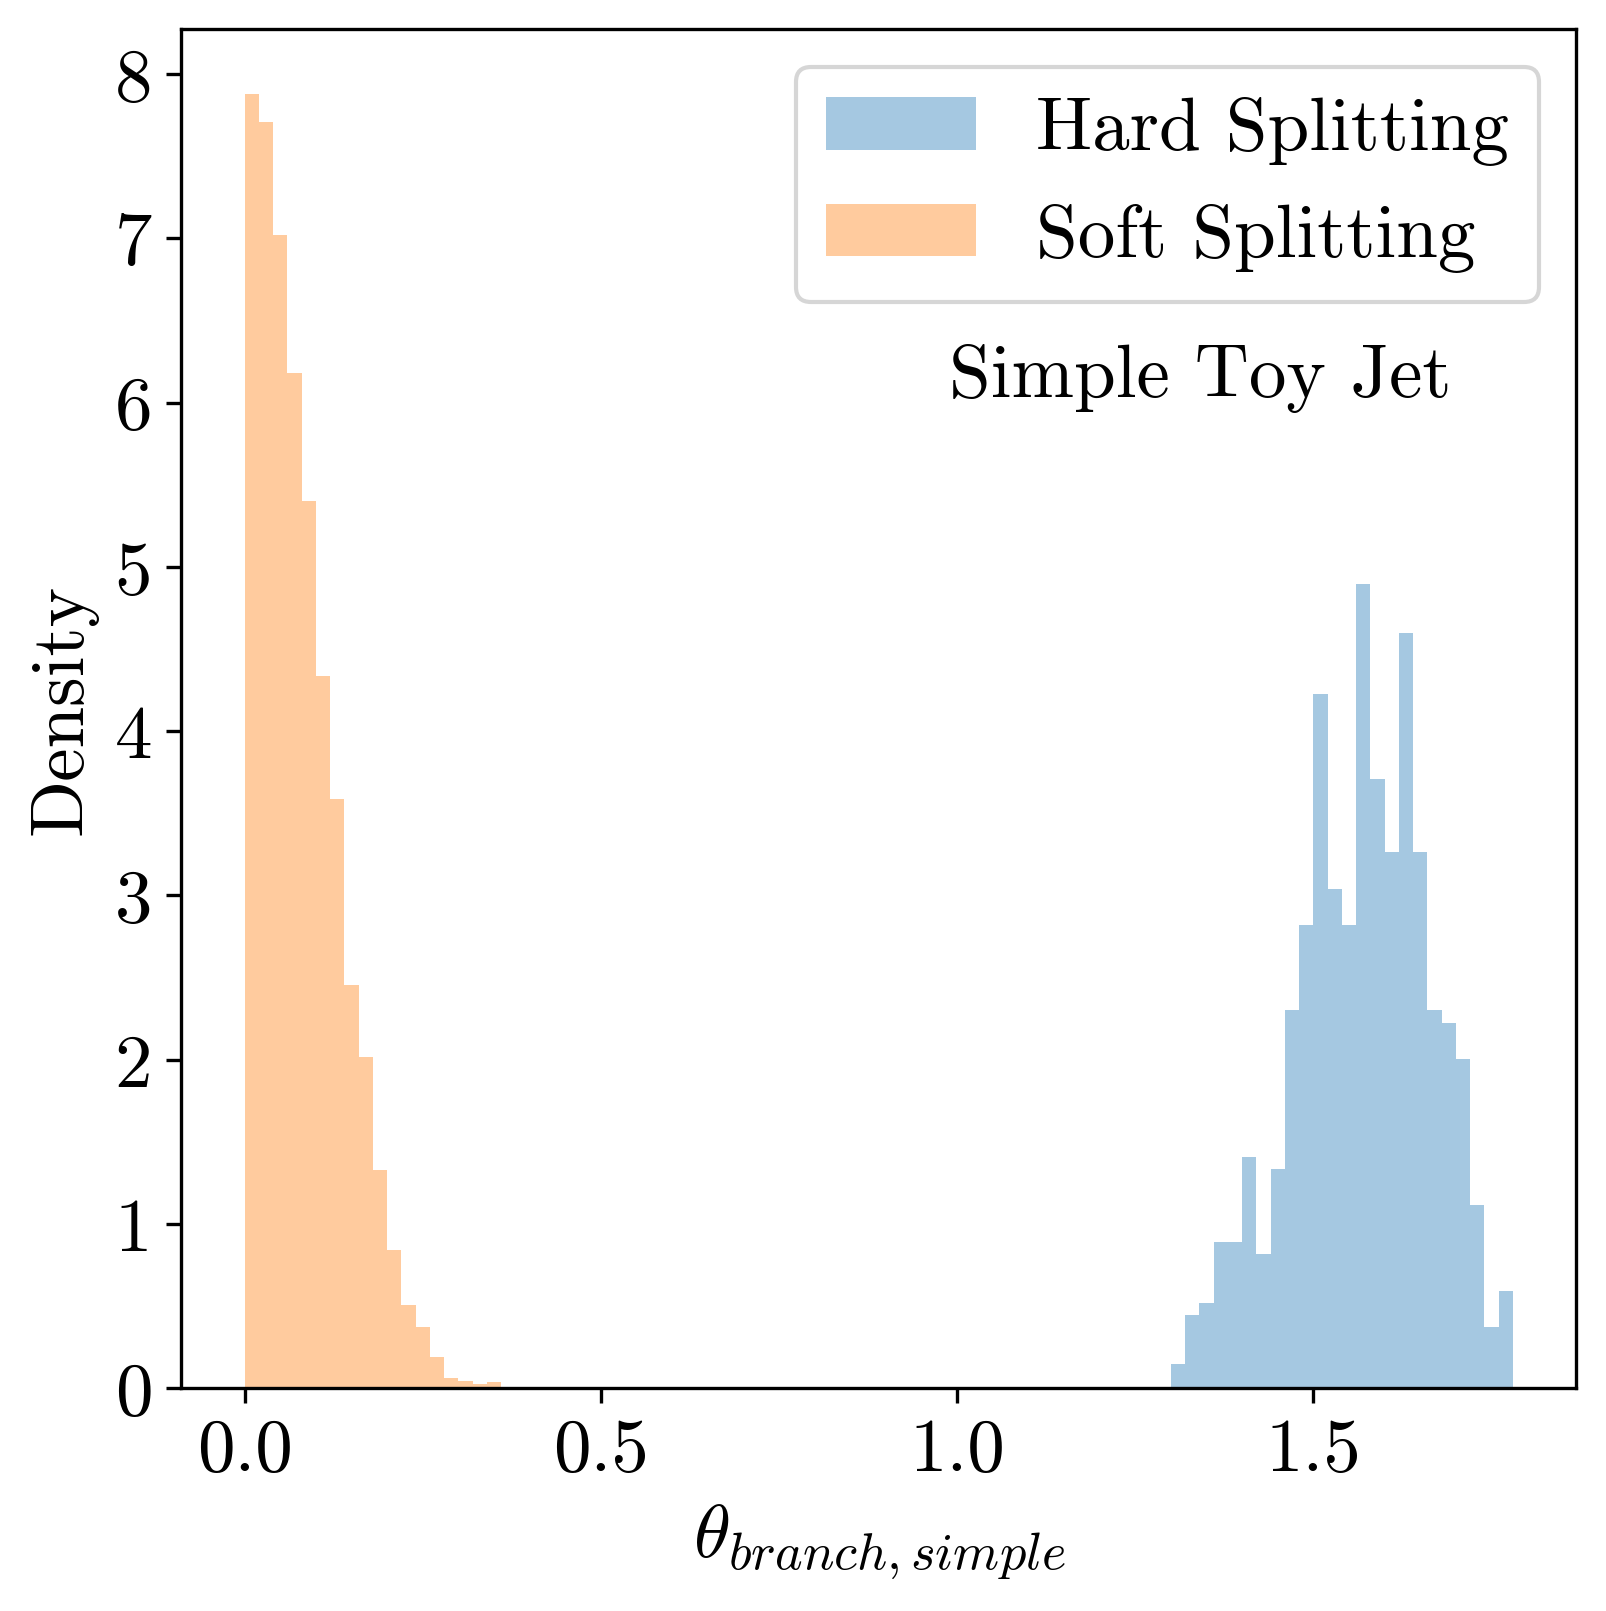

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.thetahard,alpha=0.4,bins=np.arange(0,1.8,0.02),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.thetasoft,alpha=0.4,bins=np.arange(0,1.8,0.02),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$\theta_{branch, simple}$')
ax.set_ylabel('Density')
ax.text(0.55, 0.73, 'Simple Toy Jet', transform=ax.transAxes)

fig.savefig('./figures/paper_JHEP/SimpleToyJet_Theta.png')
fig.savefig('./figures/paper_JHEP/SimpleToyJet_Theta.pdf')

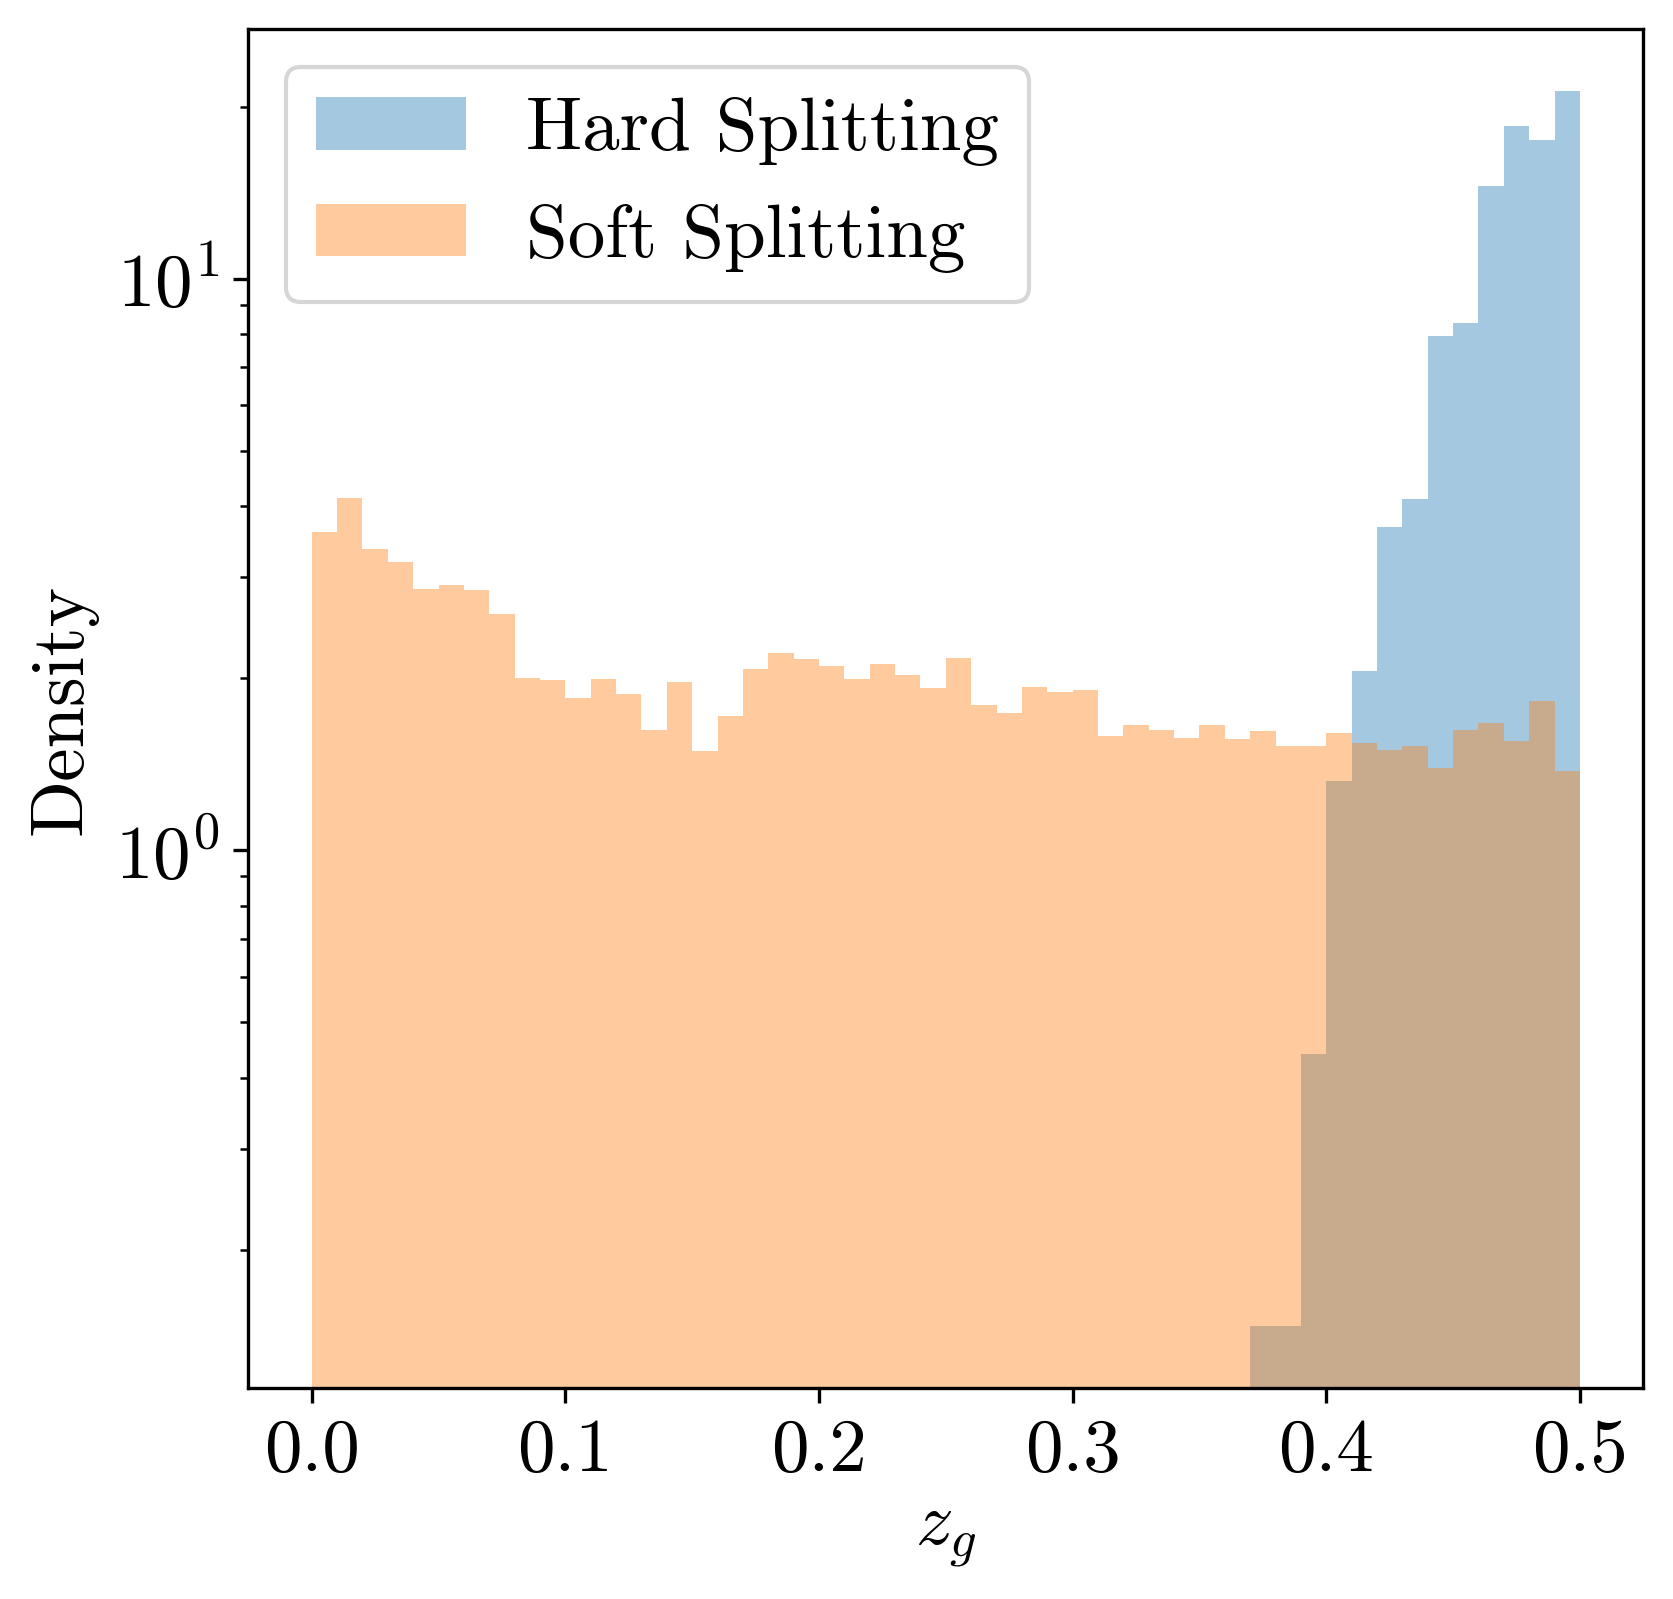

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
ax.set_yscale('log')

fig.savefig('./figures/paper/simple_toyjet_momentum_sharing_Log.png')
fig.savefig('./figures/paper/simple_toyjet_momentum_sharing_Log.pdf')

Text(0, 0.5, 'Density')

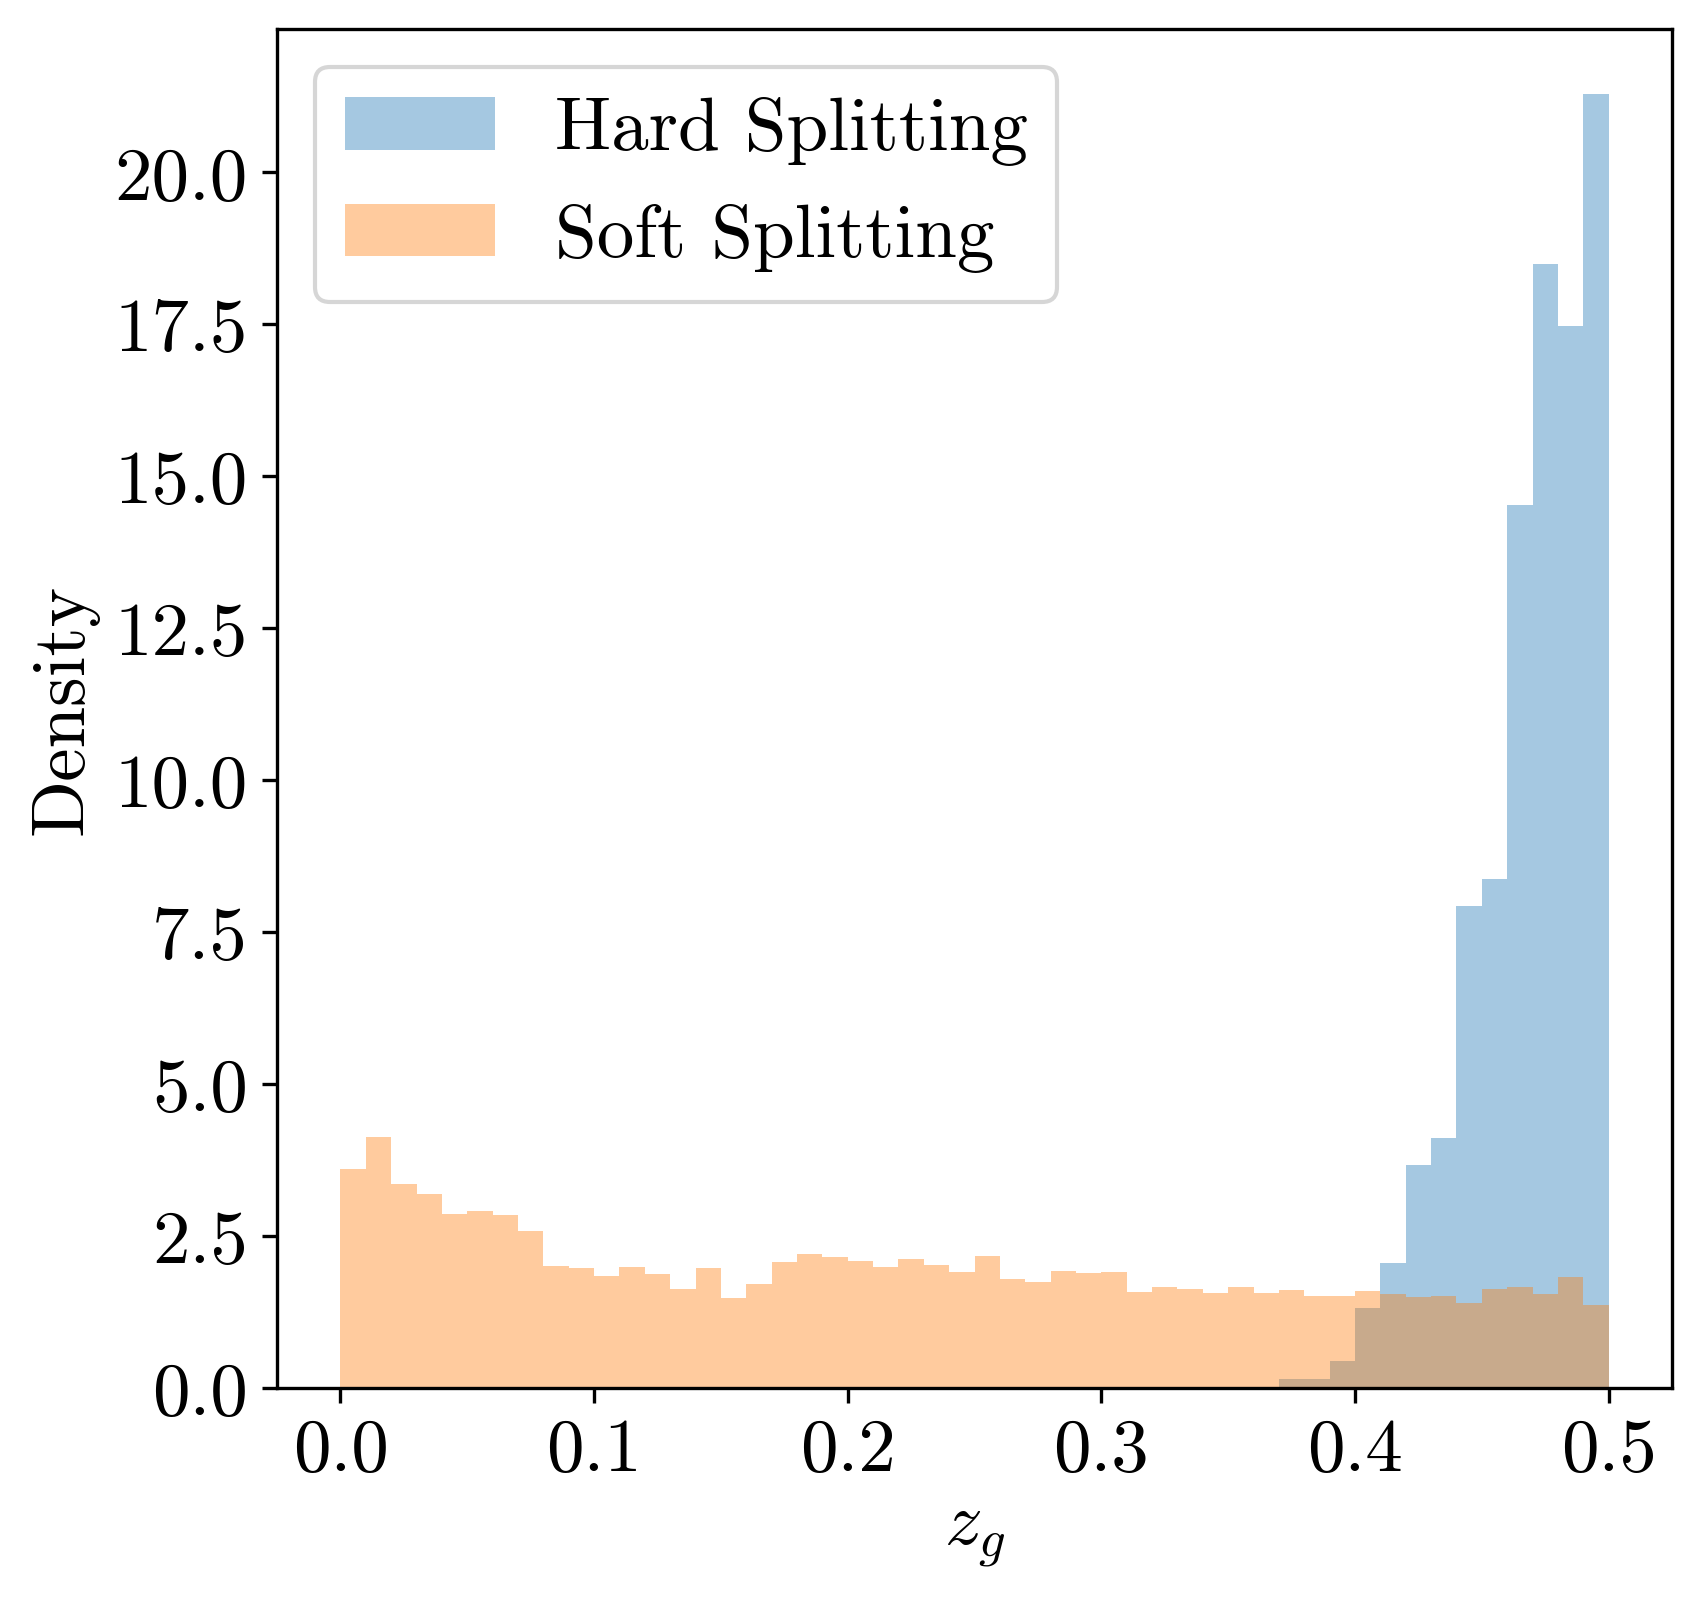

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
#fig.savefig('./figures/paper/simple_toyjet_momentum_sharing.png')
#fig.savefig('./figures/paper/simple_toyjet_momentum_sharing.pdf')

In [27]:
data_sig_2p_8part.shape

NameError: name 'data_sig_2p_8part' is not defined

In [48]:
def plot_event(pfcands, name):

    pt = pfcands[:,0]
    eta = pfcands[:,1]
    phi = pfcands[:,2]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(eta,phi,s=pt*10, alpha=0.2)
    ax.set_xlabel('eta')
    ax.set_ylabel('phi')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    fig.savefig(f'figures/{name}.png')
plot_event(data_sig_3p_8part[99].reshape(-1,3), "top_3p_8part")

In [50]:
sig_3p_8part = jet_data_generator("signal",0.00005, 3, 8, True)

In [51]:
data_sig_3p_8part = sig_3p_8part.generate_dataset(100)

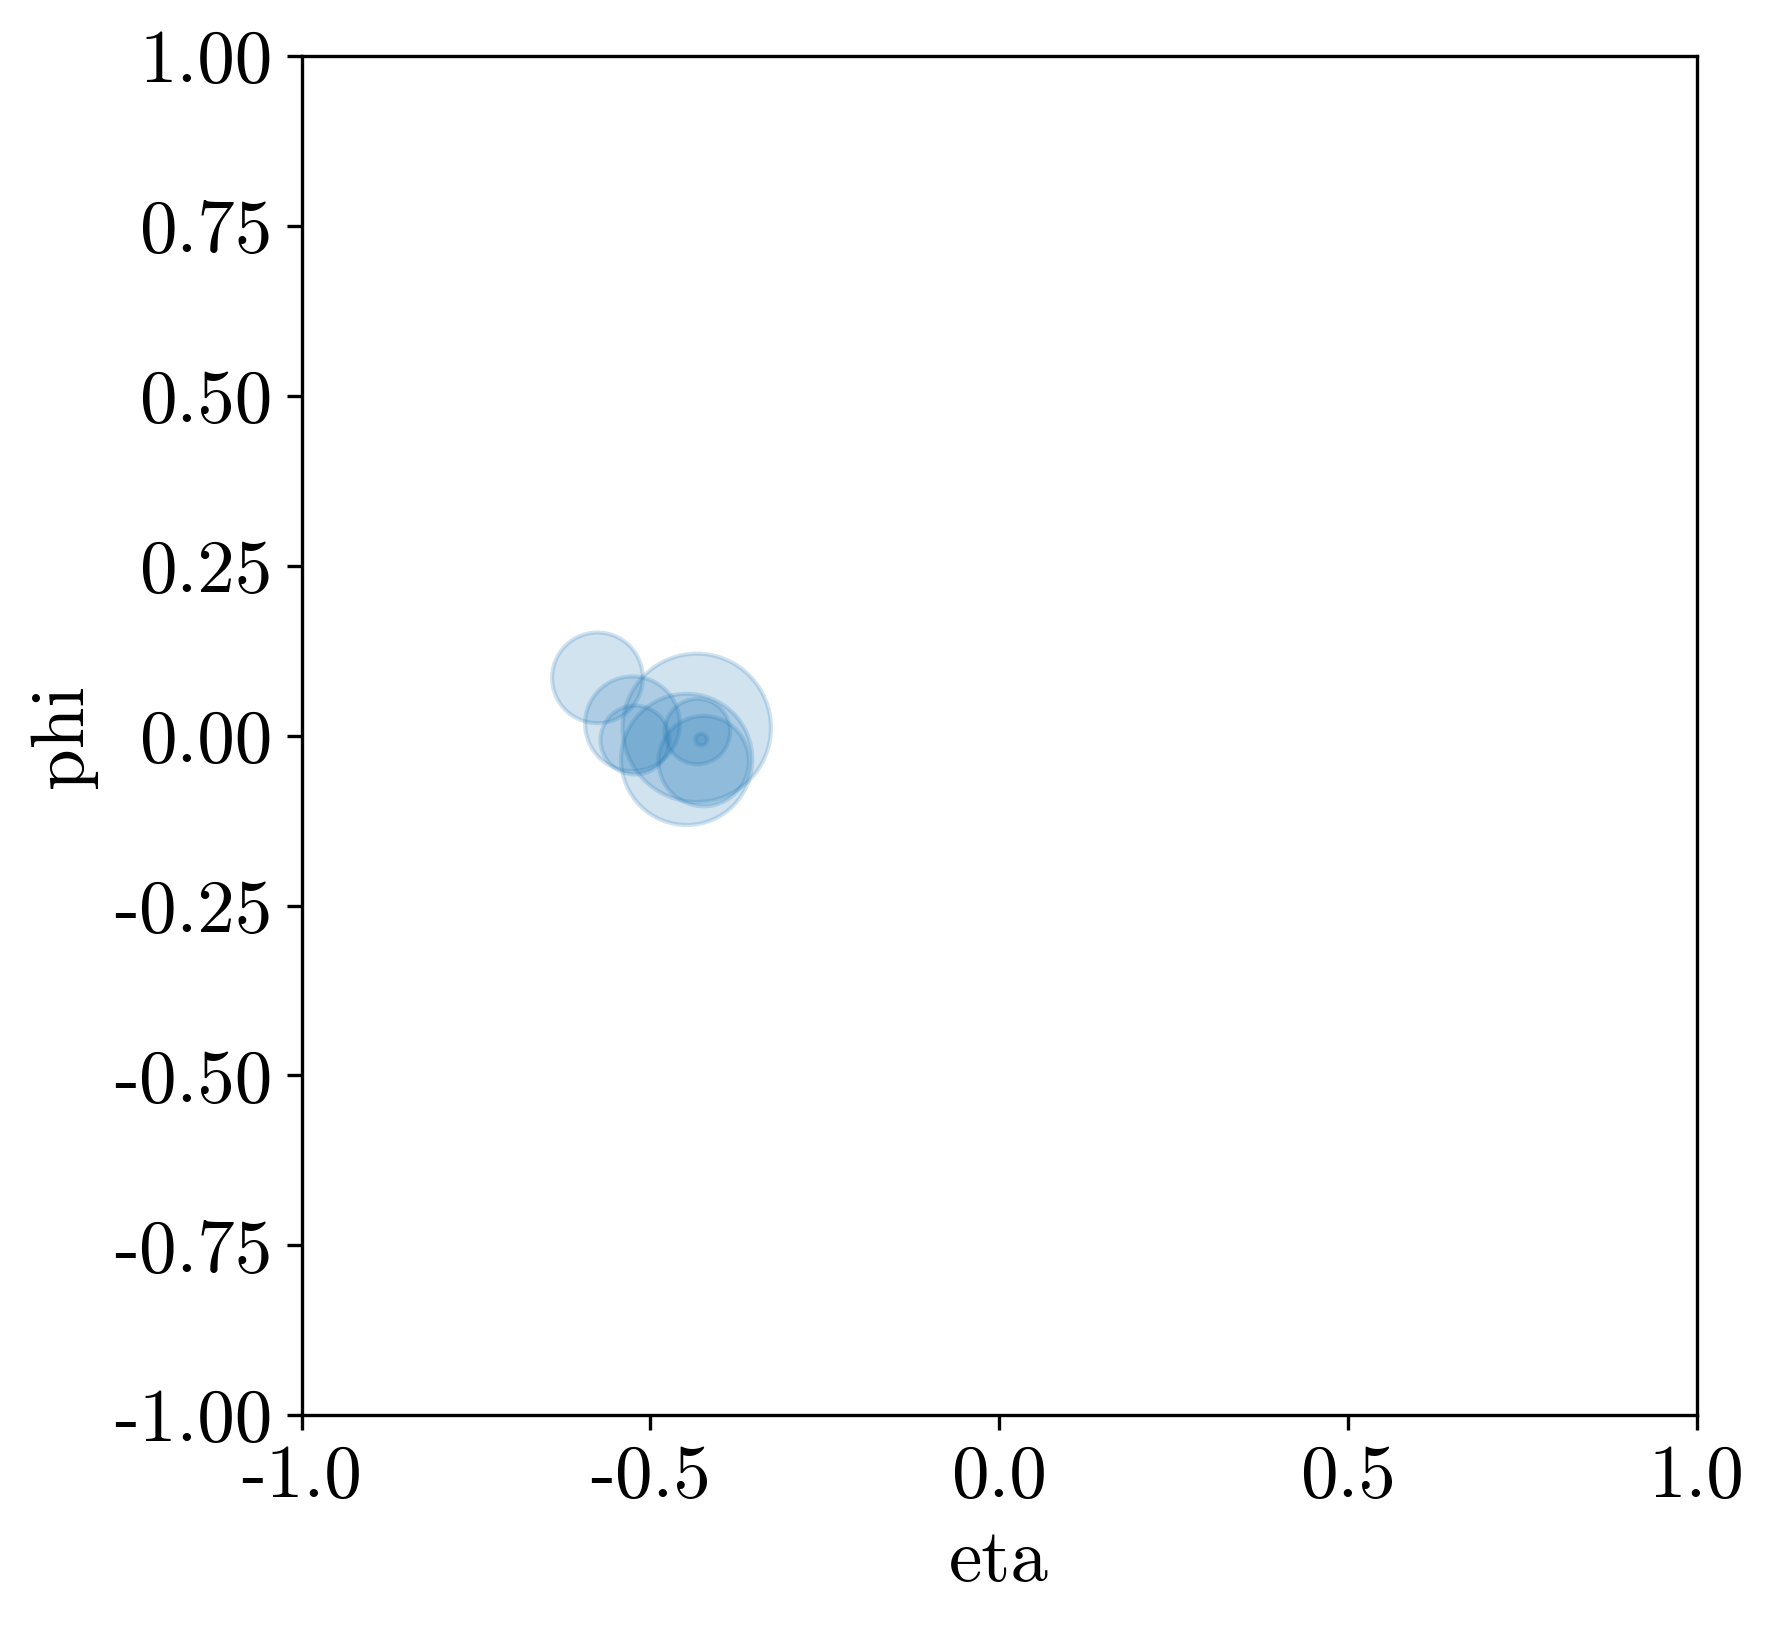

In [55]:
plot_event(data_sig_3p_8part[99].reshape(-1,3), "top_3p_8part")

In [ ]:
start = time.time()
data_sig_2p_2part = sig_2p_2part.generate_dataset(100)
end = time.time()
print(end-start)

In [ ]:
plot_event(data_sig_2p_2part[5].reshape(-1,3), "sig_2p_2part")

In [ ]:
sig_2p_3part = jet_data_generator("signal",0.00005, 2, 3)

In [ ]:
data_sig_2p_3part = sig_2p_3part.generate_dataset(100)


In [ ]:
plot_event(data_sig_2p_3part[5].reshape(-1,3), "sig_2p_3part")

In [ ]:
sig_3p_3part = jet_data_generator("signal",0.00005, 3, 3)

In [ ]:
data_sig_3p_3part = sig_3p_3part.generate_dataset(100)


In [ ]:
plot_event(data_sig_3p_3part[1].reshape(-1,3), "sig_3p_3part")

## 